###### Doing the CNN based aproach!

In [ ]:
print("hello")

In [159]:
import numpy as np
import h5py
import matplotlib.pyplot  as plt
import pandas as pd
import copy

#trying torch instead because my tensorflow is to stupid to see GPU
import torch
import torchvision
import torchvision.transforms as transforms


In [160]:
device = torch.device("cuda:0")
print(device)

cuda:0


# Implement Upsampling and Training with Validation Set and storing best model of validation set !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! (upsampling is done, now validation set is missing)

In [161]:
#opening the training file:
filename = "datasets/phase_4_TRAIN_22d5ff80542b443e_e2a955e_MLPC2021_melspect.h5"

h5_train = h5py.File(filename,'r')

In [162]:
#list(h5_train.keys())

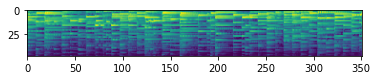

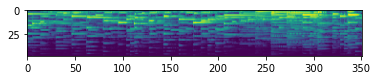

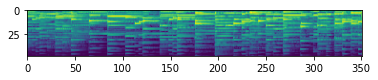

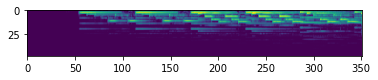

In [163]:
#looking at a few examples to get a feeling for it:
snippets=['GG-02-007','AH-02-003','AS-02-006','AH-01-000']
for snip in snippets:
    plt.imshow(h5_train[snip])
    plt.show()

#### Doing training set distribution ajustments:

In [164]:
#loading further training data
df = pd.read_csv("datasets/phase_3_TRAIN_7d499bff69ca69b6_6372c3e_MLPC2021_generic.csv")
df.head()

,id,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,essentia_spectral_centroid_mean,essentia_spectral_centroid_stdev,...,midlevel_features_rhythm_complexity,midlevel_features_rhythm_stability,midlevel_features_dissonance,midlevel_features_tonal_stability,midlevel_features_minorness,score_mode,score_key_strength,mean_A,mean_V,quadrant
0,GG-01-000,0.206445,0.131383,13.998791,58.329521,3.1,0.539736,0.193987,3367.790527,3684.124268,...,-0.303987,-0.053306,-0.325228,0.347745,-0.119278,0.0,0.795727,50.689655,2.724138,1
1,GG-01-001,0.145753,0.057971,3.533264,75.166183,4.2,0.476832,0.123564,1395.528809,401.987610,...,-0.381182,0.120750,-0.479266,0.451572,-0.064252,0.0,0.844387,50.689655,2.724138,1
2,GG-01-002,0.149111,0.059011,3.337368,82.753929,4.3,0.457741,0.132359,1318.759644,289.306152,...,-0.337422,0.103853,-0.388214,0.430684,-0.226197,0.0,0.758119,50.689655,2.724138,1
3,GG-01-003,0.163914,0.057474,3.078172,79.024742,4.1,0.504427,0.121134,1258.258423,262.561310,...,-0.314282,0.118872,-0.335902,0.314371,-0.006619,1.0,0.747180,50.689655,2.724138,1
4,GG-01-004,0.157382,0.054116,2.682208,59.633064,3.9,0.503377,0.121658,1244.375122,260.756195,...,-0.302913,-0.002940,-0.395495,0.368037,-0.162711,0.0,0.710480,50.689655,2.724138,1


In [165]:
#create tags_dataframe:
X_tags=pd.DataFrame()
X_tags['id']=df['id']


#extract piece_id and pianist to later allow by piece/pianist/both cross validation
def extractPianist(x):
    return x[0:2]
def extract_piece_id(x):
    return x[3:5]
def extract_snippet_number(x):
    return x[6:9]

#get relevant information from dataframe
X_tags['Piece_id']=X_tags['id'].apply(extract_piece_id)
X_tags['Snippet_number']=X_tags['id'].apply(extract_snippet_number)
X_tags['class']=df['quadrant']
X_tags['mean_V']=df['mean_V']
X_tags['mean_A']=df['mean_A']
X_tags['score_mode']=df['score_mode']

#get list of pianists and pieces!
piece_list=list(set(X_tags['Piece_id']))

In [166]:
#get distribution of classes per piece
piece_dist_list=[]
piece_dist_list_perecent=[]
for piece in piece_list:
    mylist=[]
    for i in range(4):
        mylist.append(len(X_tags.loc[(X_tags['Piece_id'] == piece) & (X_tags['class']==i+1)]))
    piece_dist_list.append(mylist)
    mylist=[element/sum(mylist) for element in mylist]
    piece_dist_list_perecent.append(mylist)
piece_dist_list

[[0, 0, 194, 0],
 [0, 22, 136, 0],
 [0, 0, 142, 0],
 [32, 0, 0, 0],
 [33, 0, 0, 43],
 [53, 0, 0, 0],
 [22, 0, 0, 48],
 [37, 0, 0, 0],
 [8, 0, 0, 74],
 [0, 0, 195, 0],
 [22, 0, 0, 13],
 [0, 42, 12, 0],
 [0, 0, 158, 0],
 [22, 0, 0, 0],
 [0, 0, 32, 44],
 [18, 4, 0, 7],
 [14, 33, 0, 0],
 [8, 0, 0, 45],
 [35, 0, 0, 0],
 [0, 7, 37, 0],
 [0, 9, 94, 0],
 [0, 16, 62, 0],
 [8, 0, 19, 52],
 [13, 0, 0, 26],
 [36, 0, 0, 0],
 [6, 24, 0, 0],
 [0, 0, 67, 12],
 [11, 0, 0, 59],
 [5, 0, 4, 19],
 [59, 0, 0, 30],
 [0, 0, 127, 0],
 [0, 16, 60, 0],
 [5, 21, 9, 0],
 [26, 0, 0, 0],
 [0, 26, 21, 8],
 [0, 54, 11, 0]]

In [167]:
#makeing training set based only on a few handpicked piece ids

In [168]:
#selected_list=[,'15','18','29','09','18','29','03','31','22']#yes adding piece indices multiple times 
# does do upsampling
selected_list=['14', '03', '34',  '28', '29',  '21','38','11', 
               '25',  '26', '02', '41', '15',  '36', '16', '19', '20', 
               '27', '39', '30', '24', '04', '12', '22', '35', '47', '18', 
               '45', '37']#emoved:'08',   
Train_Snippets=[]
#and create horizontal splits:
for i,piece in enumerate(selected_list):
    vetrical_mask_train=np.zeros(0).astype(int)

    mask= X_tags[X_tags['Piece_id']==selected_list[i]].index.values.astype(int)
    vetrical_mask_train=np.concatenate((vetrical_mask_train,mask), axis=0)

    #print(vetrical_mask_test)
    #print(vetrical_mask_train)
    trainIndices=vetrical_mask_train
    
    [Train_Snippets.append(index) for index in trainIndices]


In [169]:
X_tags

,id,Piece_id,Snippet_number,class,mean_V,mean_A,score_mode
0,GG-01-000,01,000,1,2.724138,50.689655,0.0
1,GG-01-001,01,001,1,2.724138,50.689655,0.0
2,GG-01-002,01,002,1,2.724138,50.689655,0.0
3,GG-01-003,01,003,1,2.724138,50.689655,1.0
4,GG-01-004,01,004,1,2.724138,50.689655,0.0
...,...,...,...,...,...,...,...
2602,RT-47-029,47,029,3,-0.896552,20.344828,0.0
2603,RT-47-030,47,030,3,-0.896552,20.344828,0.0
2604,RT-47-031,47,031,3,-0.896552,20.344828,0.0
2605,RT-47-032,47,032,3,-0.896552,20.344828,0.0


In [170]:
print(set(X_tags['Piece_id']))

{'47', '08', '15', '18', '38', '14', '01', '05', '34', '16', '37', '03', '24', '29', '02', '27', '11', '25', '09', '35', '36', '19', '46', '22', '41', '39', '12', '26', '45', '30', '28', '32', '20', '21', '04', '31'}


In [171]:
upsample_training=True
#creating equal distribution of classes in training set (upsampling)
if upsample_training:

    #all snippets that are in the training set:
    temp_df=X_tags.iloc[Train_Snippets]

    #get class distributions
    class_dist_list=[]
    for i in range(4):
        class_dist_list.append(len(temp_df.loc[temp_df['class']==i+1]))
    print(class_dist_list)
    max_snippets= max(class_dist_list)
    print(f'maximum snippets { max(class_dist_list)}')

    #randomly duplicate snippets in small classes to reach even distribution:
    for i in range(4):
        dup_num= max_snippets-class_dist_list[i]
        #print(dup_num)
        snippet_ids=temp_df[temp_df['class']==i+1].index.values.astype(int)
        #print(snippet_ids)
        temp_list=np.random.choice(snippet_ids, size=dup_num, replace=True)
        #print(temp_list)
        [Train_Snippets.append(index) for index in temp_list]

[371, 182, 1154, 380]
maximum snippets 1154


In [172]:
#double_checking:
temp_df=X_tags.iloc[Train_Snippets]

#get class distributions
class_dist_list=[]
for i in range(4):
    class_dist_list.append(len(temp_df.loc[temp_df['class']==i+1]))
print(class_dist_list)
max_snippets= max(class_dist_list)
print(f'maximum snippets { max(class_dist_list)}')

[1154, 1154, 1154, 1154]
maximum snippets 1154


In [173]:
#creating inverse test set:
print(len(X_tags))
#create_indices
indices=[]
for i in range(len(X_tags)):
    indices.append(i)

temp_test = np.ones(len(X_tags), np.bool)
temp_test[Train_Snippets] = 0

#masking the right inidices:
x = [True, False, True, False]
y = ["a", "b", "c", "d"]

Test_Snippets=[b for a, b in zip(temp_test, indices) if a]

print(len(Test_Snippets))

2607
520


<ipython-input-173-68c0ca222f06>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp_test = np.ones(len(X_tags), np.bool)


In [174]:
#creating equal distribution of classes in TEST set (upsampling)

#all snippets that are in the training set:
temp_df=X_tags.iloc[Test_Snippets]
org_temp_df=X_tags

#get class distributions
class_dist_list=[]
org_class_dist=[]
for i in range(4):
    class_dist_list.append(len(temp_df.loc[temp_df['class']==i+1]))
    org_class_dist.append(len(org_temp_df.loc[org_temp_df['class']==i+1]))
print(org_class_dist)
print(class_dist_list)
max_snippets= max(class_dist_list)
print(f'maximum snippets { max(class_dist_list)}')

#randomly duplicate snippets in small classes to reach even distribution:
for i in range(4):
    dup_num= org_class_dist[i]-class_dist_list[i]#it was before: max_snippets-class_dist_list[i]
    print(dup_num)
    
    snippet_ids=temp_df[temp_df['class']==i+1].index.values.astype(int)
    #print(snippet_ids)
    temp_list=np.random.choice(snippet_ids, size=dup_num, replace=True)
    #print(temp_list)
    [Test_Snippets.append(index) for index in temp_list]

[473, 274, 1380, 480]
[102, 92, 226, 100]
maximum snippets 226
371
182
1154
380


In [175]:
#checking on test set distribution:
temp_df=X_tags.iloc[Test_Snippets]

#get class distributions
class_dist_list=[]
for i in range(4):
    class_dist_list.append(len(temp_df.loc[temp_df['class']==i+1]))
print(class_dist_list)
max_snippets= max(class_dist_list)
print(f'maximum snippets { max(class_dist_list)}')

[473, 274, 1380, 480]
maximum snippets 1380


In [176]:
#loading all traing mel_spectrograms
X_train=[h5_train[index] for index in list(h5_train)]
X_train=np.array(X_train)
df = pd.read_csv("datasets/phase_3_TRAIN_7d499bff69ca69b6_6372c3e_MLPC2021_generic.csv")
# drop target value, student annotations and string ID from input features:
X_feature = df.drop(columns=['quadrant','mean_A','mean_V','id','score_mode','score_key_strength'])
X_feature = X_feature.to_numpy()
print(X_feature.shape)

X_test=X_train[Test_Snippets]
X_train=X_train[Train_Snippets]

X_feature_train=X_feature[Train_Snippets]
X_feature_test=X_feature[Test_Snippets]

print(len(X_train))
len(X_test)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001D72BDE43A0>
Traceback (most recent call last):
  File "E:\Anaconda3\envs\AI\lib\site-packages\torch\utils\data\dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "E:\Anaconda3\envs\AI\lib\site-packages\torch\utils\data\dataloader.py", line 1291, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


(2607, 87)
4616


2607

In [177]:

# we want to predict the quadrant:
control=df['score_mode'].values
y_train = df['score_mode'].values
tem_train=[]
[tem_train.append(1 if element >0 else -1) for element in y_train]
y_train=np.float32(tem_train)
# we want to predict the quadrant:

tem_train=[]
y_test = (df['score_mode'].values)
[tem_train.append(1 if element >0 else -1) for element in y_test]
y_test=np.float32(tem_train)

#restricting to spectrograms of selected pieces
y_train=y_train[Train_Snippets]
y_test= y_test[Test_Snippets]

print(y_train[1500])
print(control[Train_Snippets][1500])
print(y_train)
print(y_test)
print(control[Train_Snippets])

-1.0
0.0
[ 1. -1.  1. ...  1. -1.  1.]
[-1. -1. -1. ... -1. -1. -1.]
[1. 0. 1. ... 1. 0. 1.]


In [178]:
df['score_mode'].values

array([0., 0., 0., ..., 0., 0., 1.])

(48, 351)

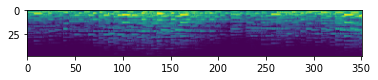

In [179]:
plt.imshow(X_train[0])
X_train[0].shape

In [180]:
#check if they are all of the same shape:
shapes =set()
for spectrogram in X_train:
    shapes.add(spectrogram.shape)
    

In [181]:
shapes

{(48, 351)}

In [182]:
# ==> yes they are all same shape
print(len(X_train))
print(len(y_train))
y_train
X_train.shape

4616
4616


(4616, 48, 351)

In [183]:
torch.cuda.is_available()

True

In [185]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 10


myTrainset = []
for i in range(len(X_train)):
    #myTrainset.append((np.array([X_train[i]]),
    #                   np.long(y_train[i]-1)))#pytorch on windows requires lables to be type long also the need to be [0-3] instead of [1-4]
    #data augmentation
    #idea adding random noise:
    augmentaion_level=2
    drop_percentage=1#
    #print(X_train[i].dtype)
    for j in range(augmentaion_level):
        element=X_train[i]
        features=X_feature_train[i]
        #print(np.random.rand(1))
        if j==0:
            pass
        elif j==1:
            element=np.fliplr(element)
            
        elif j==2:
            element=np.fliplr(np.flipud(element))
        else:
            element=np.flipud(element)
        '''
        element=element
        #print(element)


        #print((X_train[i]+Noise).shape)
        Noise=np.random.normal(0,0.5,(48,351)).astype(np.float32)
        element=np.add(X_train[i],Noise)
        #print(element.dtype)
        '''
        #np.compat.long
        myTrainset.append((np.array([element]),
                       np.array([np.float32(y_train[i])])))#pytorch on windows requires lables to be type long also the need to be [0-3] instead of [1-4]
    #myTrainset.append((np.array([np.flipud(X_train[i])]),
    #                   np.long(y_train[i]-1)))#pytorch on windows requires lables to be type long also the need to be [0-3] instead of [1-4]
    #myTrainset.append((np.array([np.flipud(np.fliplr(X_train[i]))]),
    #                   np.long(y_train[i]-1)))
myTestset = []
for i in range(len(X_test)):
    #first normalize array:
    X_test[i]=(X_test[i]-np.mean(X_test[i]))/np.std(X_test[i])
    myTestset.append((np.array([X_test[i]]),np.array([np.float32(y_train[i])])))#pytorch on windows requires lables to be type long also the need to be [0-3] instead of [1-4]
    
trainset = myTrainset
#print(myTrainset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True,num_workers=2)

testset = myTestset

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('happy', 'angry','relaxed','sad')

In [186]:
len(trainset)

9232

In [192]:
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(seed=42)
torch.manual_seed(42)
import random
random.seed(0)

class Net(nn.Module):

    #the following achieved 30% peak performance on balanced test set

    def __init__(self):
        super().__init__()
        self.activation= nn.SELU()
        
        self.pool_v=nn.MaxPool2d((2, 1))
        self.conv1= nn.Conv2d(1, 12,(11,1),padding=(4,0))
        self.conv2= nn.Conv2d(12, 12,(11,1),padding=(4,0))
        self.conv3= nn.Conv2d(12, 12,(11,1),padding=(5,0))
        
        #now we have 5*351
        self.avpool=nn.AvgPool2d((1, 351))#AvgPool2d
        
        self.fc1 = nn.Linear(60, 1)


        
    def forward(self, x):
        #print(x.shape)
        #do dropout:
        #idea:
        #print(x.shape)
        x = self.pool_v(self.activation(self.conv1(x)))
        x = self.pool_v(self.activation(self.conv2(x)))
        x= self.pool_v(self.activation(self.conv3(x)))
        #print(x.shape)
        #no we are finished with 1 d convolutions add it all up
        x= self.avpool(x)
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = self.fc1(x)
        #print(x.shape)
        return x

net = Net()
net.to(device)

Net(
  (activation): SELU()
  (pool_v): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 12, kernel_size=(11, 1), stride=(1, 1), padding=(4, 0))
  (conv2): Conv2d(12, 12, kernel_size=(11, 1), stride=(1, 1), padding=(4, 0))
  (conv3): Conv2d(12, 12, kernel_size=(11, 1), stride=(1, 1), padding=(5, 0))
  (avpool): AvgPool2d(kernel_size=(1, 351), stride=(1, 351), padding=0)
  (fc1): Linear(in_features=60, out_features=1, bias=True)
)

In [193]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [196]:
printing_freq=300
max_accuracy=-np.inf
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #print(inputs.is_cuda)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print(labels)
        #print(outputs.t())
        loss =  nn.functional.mse_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % printing_freq == printing_freq-1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / printing_freq))
            running_loss = 0.0
            
            correct = 0
            total = 0
            prediction_result_set=[]#To see if really everything was majority class
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader: #testloader:#Need to change that to test loader later!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    # calculate outputs by running images through the network
                    
                    outputs = net(images)
                    #print(outputs)

                    loss =  nn.functional.mse_loss(outputs, labels)
                    

                    #calculate_correctly_classified_results:
                    for k,out in enumerate(outputs):
                        if (labels[k])>0 and outputs[k]>0:
                            correct +=1
                        if (labels[k])<0 and outputs[k]<0:
                            correct +=1
                        
                    #print(outputs.is_cuda)
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    hi= predicted.cpu().detach().numpy()
                    [prediction_result_set.append(element) for element in hi]

                    total += labels.size(0)


            print(f'Accuracy of the network on the test images:{correct / total} (correct:{correct})')
            
            if (correct / total) >max_accuracy:
                max_accuracy=(correct / total)
                print("stroing this version of the network!")
                PATH = './CNN.pth'
                torch.save(net.state_dict(), PATH)

print('Finished Training')

[1,   300] loss: 0.784
Accuracy of the network on the test images:0.5005753739930955 (correct:1305)
stroing this version of the network!
[1,   600] loss: 0.750
Accuracy of the network on the test images:0.49904104334484084 (correct:1301)
[1,   900] loss: 0.747
Accuracy of the network on the test images:0.5009589566551592 (correct:1306)
stroing this version of the network!
[2,   300] loss: 0.706
Accuracy of the network on the test images:0.49904104334484084 (correct:1301)
[2,   600] loss: 0.688
Accuracy of the network on the test images:0.5090141925584963 (correct:1327)
stroing this version of the network!
[2,   900] loss: 0.708
Accuracy of the network on the test images:0.49750671269658614 (correct:1297)
[3,   300] loss: 0.690
Accuracy of the network on the test images:0.5021097046413502 (correct:1309)
[3,   600] loss: 0.658


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001D72BDE43A0>
Traceback (most recent call last):
  File "E:\Anaconda3\envs\AI\lib\site-packages\torch\utils\data\dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "E:\Anaconda3\envs\AI\lib\site-packages\torch\utils\data\dataloader.py", line 1291, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Accuracy of the network on the test images:0.4982738780207135 (correct:1299)
[3,   900] loss: 0.635
Accuracy of the network on the test images:0.49750671269658614 (correct:1297)
[4,   300] loss: 0.624
Accuracy of the network on the test images:0.49904104334484084 (correct:1301)
[4,   600] loss: 0.591
Accuracy of the network on the test images:0.5051783659378596 (correct:1317)
[4,   900] loss: 0.605
Accuracy of the network on the test images:0.5024932873034139 (correct:1310)
[5,   300] loss: 0.578
Accuracy of the network on the test images:0.5055619485999233 (correct:1318)
[5,   600] loss: 0.581
Accuracy of the network on the test images:0.5017261219792866 (correct:1308)
[5,   900] loss: 0.560
Accuracy of the network on the test images:0.5036440352896049 (correct:1313)
[6,   300] loss: 0.530
Accuracy of the network on the test images:0.5028768699654775 (correct:1311)
[6,   600] loss: 0.511
Accuracy of the network on the test images:0.5055619485999233 (correct:1318)
[6,   900] loss: 0.55

KeyboardInterrupt: 

In [ ]:
#epochs measured with augmentation level 2

In [152]:
#kernel size 12 only left right flipped data: predicting mean_V directly
#it takes at least 12 epochs or so to see good results better than 50%
#best result agter 14 epochs
#improvement after 19 epochs ~54 %

#mean_V set to -1/1
#after 16 epochs ~55 %

In [153]:
#kernel size 20 only left right flipped data predicting mean_V directly
#significant performance increase after 13 epochs ~52%
#after 20 epochs we saw a peak but no more than ~52%

In [ ]:
net = Net()
PATH = './pth_files/CNN.pth'
net.load_state_dict(torch.load(PATH))
net.to(device)

In [ ]:
correct = 0
total = 0
prediction_result_set=[]#To see if really everything was majority class
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader: #testloader:#Need to change that to test loader later!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        images, labels = data
        
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        hi= predicted.cpu().detach().numpy()
        [prediction_result_set.append(element) for element in hi]
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

print("To check if it predicted only majority classes, here are the classes it predicted:")
print(prediction_result_set)

In [ ]:
#it only gets baseline accuracy! => Need to have a better distribution of training samples
#also since loss is not going down during training; I assume that the model is to small to get anything